## Importações e Dados

In [1]:
! pip install pmdarima

     -------------------------------------- 615.0/615.0 kB 4.8 MB/s eta 0:00:00
     ---------------------------------------- 2.8/2.8 MB 25.4 MB/s eta 0:00:00


In [2]:
import math, itertools, warnings
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import acf, pacf
from pmdarima import auto_arima
from scipy.special import boxcox, inv_boxcox
from scipy import stats

warnings.filterwarnings("ignore")


In [3]:
def ADF(data):
    result = adfuller(data)
    print(f'ADF Statistic: {result[0]}')
    print(f'n_lags: {result[2]}')
    print(f'p-value: {result[1]:.20f}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')

# -------------------------------------------------------------
def ACF_and_PACF(data):
    fig = plt.figure(figsize=(17,10))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(data, lags=30, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(data, lags=30, ax=ax2)

def plot_model_prediction(model_df, model_name, train_df, test_df):
  plt.plot(train_df['Passengers'], label = 'Train')
  plt.plot(test_df['Passengers'], label = 'Test')
  plt.plot(model_df[test_df.index.min():], label = model_name)

  plt.legend()
  plt.title(model_name)
  plt.show()

def plot_residuals(model_fit, model_name):
    residuals = pd.DataFrame(model_fit.resid)
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    residuals.plot(title=f"Residuals {model_name}", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()

In [62]:
def eval_and_plot_model(p,d,q, data_boxcox, train_diff, train, test, fitted_lambda):
    model = ARIMA(train_diff, order=(p,d,q))
    model_fit = model.fit()

    pred_diff = pd.Series(model_fit.fittedvalues, copy=True)
    pred_diff_cumsum = pred_diff.cumsum()

    pred_boxcox = pd.Series(data_boxcox, index=data_boxcox.index)
    pred_boxcox = pred_boxcox.add(pred_diff_cumsum, fill_value=0)

    pred = inv_boxcox(pred_boxcox, fitted_lambda)

    plot_model_prediction(pred, 'model ({},{},{})'.format(p,d,q), train, test)

In [102]:
def eval_model(name, min_p, max_p, min_d, max_d, min_q, max_q, train, test, data_boxcox):

  results_df = pd.DataFrame()
  for p,d,q in itertools.product(range(min_p, max_p), range(min_d, max_d), range(min_q, max_q)):

    try:
      model = ARIMA(train, order=(p,d,q))
      model_fit = model.fit()

      pred_diff = pd.Series(model_fit.fittedvalues, copy=True)
      pred_diff_cumsum = pred_diff.cumsum()

      pred_boxcox = pd.Series(data_boxcox, index=data_boxcox.index)
      pred_boxcox = pred_boxcox.add(pred_diff_cumsum, fill_value=0)

      pred = inv_boxcox(pred_boxcox, fitted_lambda)

      aic = model_fit.aic
      bic = model_fit.bic
      llf = model_fit.llf

      order = model.order
      print(order)
      prediction = pred[test.index.min():]
      actual = test['Passengers']

      mse = mean_squared_error(actual, prediction)
      rmse = np.sqrt(mse)
      mae = mean_absolute_error(actual, prediction)
      mape = np.mean(np.abs((actual - prediction) / actual)) * 100

      results = pd.DataFrame({'model':name, 'order':[order], 'AIC': aic, 'BIC': bic, 'Log-Likelihood': llf, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape})
      results_df = pd.concat([results_df, results], ignore_index=True)
    except:
      pass
    
  results_df.drop_duplicates(inplace=True)
  return results_df

In [4]:

df = pd.read_csv(r'AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


## Análise Exploratória dos dados

Verificar se existe dados nulos no dataset (nesse caso não há)

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB
None


In [6]:
df.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


#### Visualização Temporal

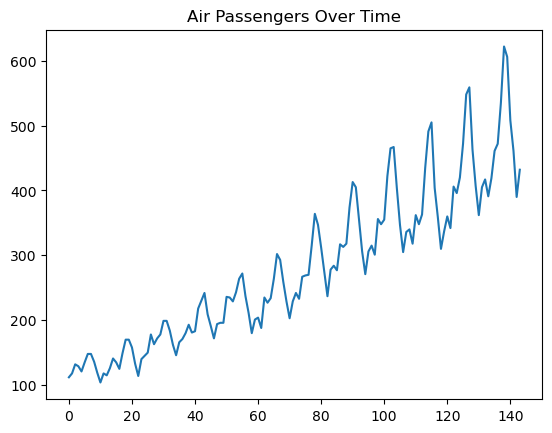

In [7]:
df['#Passengers'].plot(title='Air Passengers Over Time')
plt.show()

#### Decomposição de Séries Temporais

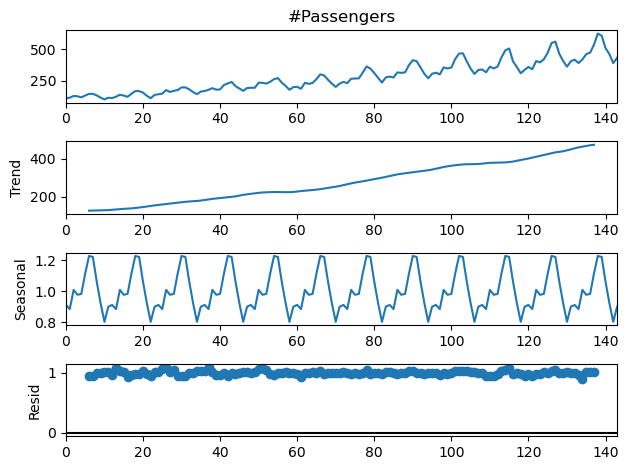

In [8]:
result = seasonal_decompose(df['#Passengers'], model='multiplicative', period=12)
result.plot()
plt.show()

Responer no relatório sobre o gráfico acima (Análise de Sazonalidade e Tendência):  
* Observe a sazonalidade: há picos e vales em meses específicos?
*   Identifique tendências: há crescimento no número de passageiros ao longo do tempo?

 #### Análise de Autocorrelação (verificar dependências temporais nos dados)

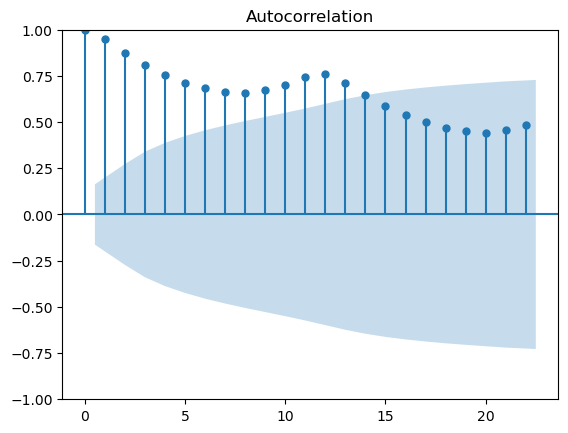

In [9]:
plot_acf(df['#Passengers'])
plt.show()

## Pré processamento dos dados

#### Limpeza dos dados

Transformar a coluna 'Month' para datetime type e renomear tanto ela quanto a coluna '#Passengers'

In [10]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df = df.rename(columns={"Month": "Date", '#Passengers': 'Passengers'})
df = df.set_index('Date')
df.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


#### 1. Diferenciação (teste Dickey-Fuller)

Teste de Dickey-Fuller aumentado (ADF) para verificar se a série é estacionária.

In [11]:
 # P-valor < 0.05 indica estacionariedade
ADF(df['Passengers'])


ADF Statistic: 0.8153688792060463
n_lags: 13
p-value: 0.99188024343764102930
Critial Values:
   1%, -3.4816817173418295
Critial Values:
   5%, -2.8840418343195267
Critial Values:
   10%, -2.578770059171598


A série não é estacionária, devemos aplicar diferenciação.

Diferenciação (técnica para transformar uma série não estacionária em estacionária, necessária para aplicar modelos como AR ou ARMA)

Por que usar diferenciação?
Se a série temporal tem tendência (valores crescentes ao longo do tempo), os modelos podem não capturar o comportamento corretamente. A diferenciação remove essa tendência.

In [12]:
df['Differenced'] = df['Passengers'].diff()

# P-valor < 0.05 indica estacionariedade
ADF(df['Differenced'].dropna())

ADF Statistic: -2.8292668241699923
n_lags: 12
p-value: 0.05421329028382647353
Critial Values:
   1%, -3.4816817173418295
Critial Values:
   5%, -2.8840418343195267
Critial Values:
   10%, -2.578770059171598


Mesmo após uma defasagem, a série ainda não apresenta características de estacionariedade, os valores críticos mais relevantes(1% e 5%) ainda são maiores que a estatística teste e o p-valor não é menor que o nível de significância de 5%.
Sendo assim, a hipótese nula não pode ser rejeitada.
Será aplicada mais uma defasagem e aseguir uma nova verificação.

In [13]:
df['Differenced'] = df['Passengers'].diff().diff()
#df['Differenced'] = df['Passengers'] - df['Passengers'].shift(periods=12)

df.dropna(inplace=True)

ADF(df['Differenced'])

ADF Statistic: -16.384231542468516
n_lags: 11
p-value: 0.00000000000000000000
Critial Values:
   1%, -3.4816817173418295
Critial Values:
   5%, -2.8840418343195267
Critial Values:
   10%, -2.578770059171598


Agora a série é estacionária. Podemos ver no gráfico abaixo a visualização de antes e depois da diferenciação

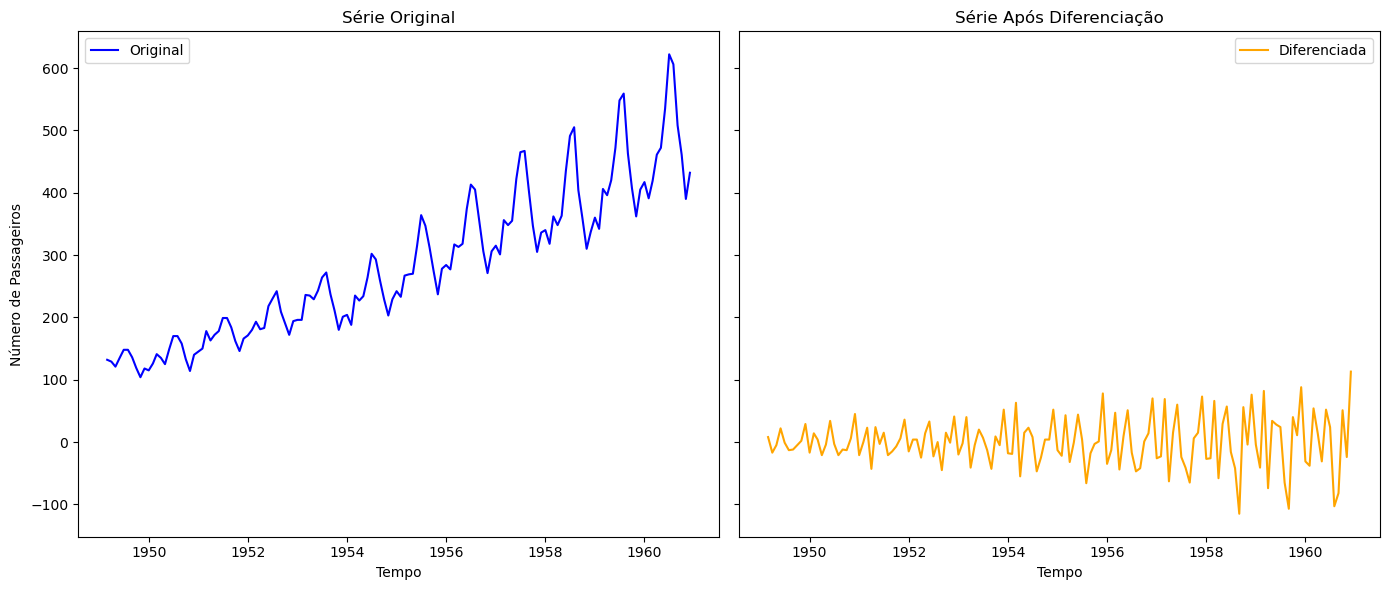

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Gráfico da série original
axes[0].plot(df['Passengers'], label='Original', color='blue')
axes[0].set_title('Série Original')
axes[0].set_xlabel('Tempo')
axes[0].set_ylabel('Número de Passageiros')
axes[0].legend()

# Gráfico da série diferenciada
axes[1].plot(df['Differenced'], label='Diferenciada', color='orange')
axes[1].set_title('Série Após Diferenciação')
axes[1].set_xlabel('Tempo')
axes[1].legend()

# Ajustar layout para evitar sobreposição
plt.tight_layout()
plt.show()

#### 2. Análise ACF e PACF

Os gráficos de autocorrelação (ACF) e autocorrelação parcial (PACF) são usados para identificar os parâmetros dos modelos.

ACF (Autocorrelation Function):

Identifica a dependência de longo prazo.
Útil para determinar
𝑞
q (ordem do modelo MA).
PACF (Partial Autocorrelation Function):

Mede a relação entre uma observação e seus lags, eliminando influências intermediárias.
Útil para determinar
𝑝
p (ordem do modelo AR).

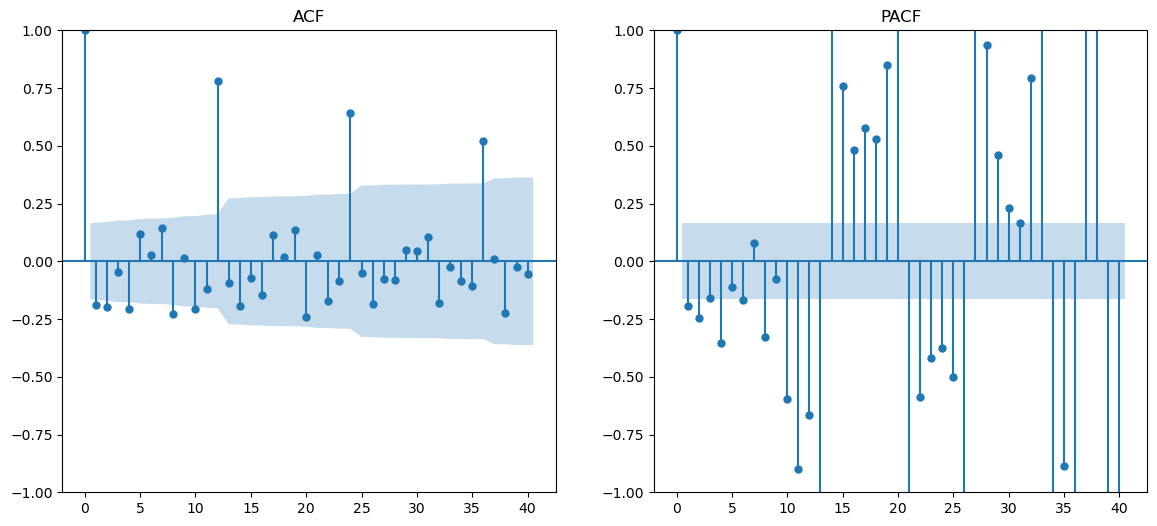

In [15]:
# ACF e PACF para a série diferenciada
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_acf(df['Differenced'].dropna(), ax=axes[0], lags=40, title='ACF')
plot_pacf(df['Differenced'].dropna(), ax=axes[1], lags=40, title='PACF')
plt.show()

Interpretação:
AR(p): Identifique o lag onde o PACF corta (decai rapidamente) para zero.
MA(q): Identifique o lag onde o ACF corta (decai rapidamente) para zero.
Use os lags identificados como candidatos para
𝑝
p e
𝑞
q.


O parâmetro
𝑝
p no modelo AR é identificado pelo primeiro lag significativo no gráfico do PACF, onde os pontos estão fora da área sombreada (limite de significância estatística).

No gráfico, os lags 1 e 2 estão claramente fora da faixa de significância. Assim:

𝑝
=
2
p=2 é o valor mais indicado para começar, já que há significância estatística nos dois primeiros lags.

## Modelagem

In [16]:
df.head()

,Passengers,Differenced
Date,,
1949-03-01,132,8.0
1949-04-01,129,-17.0
1949-05-01,121,-5.0
1949-06-01,135,22.0
1949-07-01,148,-1.0


In [17]:
length_train = math.floor(len(df["Passengers"])*0.8)

train = df[:length_train]
test = df[length_train:]

fitted_data, fitted_lambda = stats.boxcox(df['Passengers'])
print('-'*50)
print(' '*5,'fitted_lambda is: ',fitted_lambda)
print('-'*50,'\n')

data_boxcox = pd.Series(boxcox(df['Passengers'],fitted_lambda),index=df.index)

data_boxcox_diff_12= pd.Series(data_boxcox - data_boxcox.shift(periods=12), index=df.index)
data_boxcox_diff_12.dropna(inplace=True)

data_boxcox_second_order_diff= pd.Series(data_boxcox_diff_12 - data_boxcox_diff_12.shift(), index=df.index)
data_boxcox_second_order_diff.dropna(inplace=True)

train_boxcox_second_order_diff = data_boxcox_second_order_diff[:length_train]
test_boxcox_second_order_diff = data_boxcox_second_order_diff[length_train:]

--------------------------------------------------
      fitted_lambda is:  0.14584956985753103
-------------------------------------------------- 



### Modelo AR

O modelo autorregressivo (
𝐴
𝑅
(
𝑝
)
AR(p)) usa valores passados para prever os futuros. Ajuste o modelo com o parâmetro
𝑝
p identificado no PACF.

In [18]:
model_ar = ARIMA(train_boxcox_second_order_diff, order=(6,0,0))
model_fit_ar = model_ar.fit()
model_fit_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  113
Model:                 ARIMA(6, 0, 0)   Log Likelihood                 109.977
Date:                Wed, 27 Nov 2024   AIC                           -203.953
Time:                        02:51:32   BIC                           -182.134
Sample:                    04-01-1950   HQIC                          -195.099
                         - 08-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.006      0.209      0.835      -0.010       0.013
ar.L1         -0.3265      0.087     -3.737      0.000      -0.498      -0.155
ar.L2         -0.0361      0.117     -0.310      0.757      -0.265       0.192
ar.L3         -0.2151      0.095     -2.270      0.023      -0.401      -0.029
ar.L4         -0.1113      0.132     -0.845      0.398      -0.369       0.147
ar.L5          0.0273      0.092      0.296      0.767      -0.154       0.208
ar.L6          0.0295      0.092      0.322      0.747      -0.150       0.209
sigma2         0.0083      0.001      7.425      0.000       0.006       0.011
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              0.99   Prob(JB):                         0.68
Heteroskedasticity (H):               0.36   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

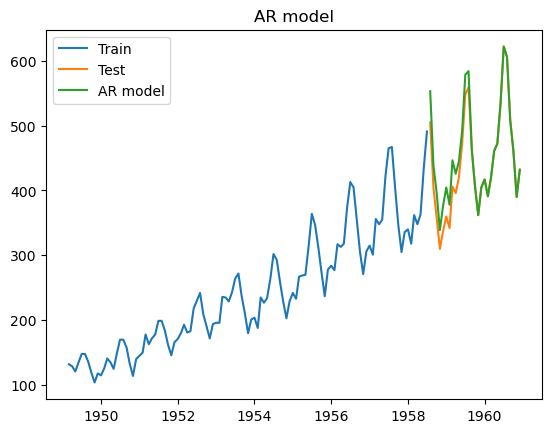

In [19]:
pred_AR_diff = pd.Series(model_fit_ar.fittedvalues, copy=True)
pred_AR_diff_cumsum = pred_AR_diff.cumsum()

pred_AR_boxcox = pd.Series(data_boxcox, index=data_boxcox.index)
pred_AR_boxcox = pred_AR_boxcox.add(pred_AR_diff_cumsum, fill_value=0)

pred_AR = inv_boxcox(pred_AR_boxcox, fitted_lambda)

plot_model_prediction(pred_AR, 'AR model', train, test)


Interpretação Geral
Validade do Modelo:

Os coeficientes
𝑎
𝑟
.
𝐿
1
ar.L1 e
𝑎
𝑟
.
𝐿
2
ar.L2 são estatisticamente significativos (
𝑝
<
0.05
p<0.05).
O modelo explica bem os dados, com resíduos normais e sem autocorrelação.
Limitação:

A presença de heterocedasticidade pode indicar que o modelo não captura bem algumas variações nos dados. Pode ser necessário ajustar isso (ex.: modelos ARCH/GARCH).
Próximos Passos:

Avaliar os resíduos para confirmar que são ruídos brancos.
Comparar o desempenho com os modelos MA e ARMA usando as métricas
AIC
AIC e
BIC
BIC.
Ajustar previsões e validá-las com o conjunto de teste.

### Modelo MA

In [20]:
model_auto = auto_arima(train_boxcox_second_order_diff, seasonal=True, trace=True,
                        information_criterion='aic',
                        error_action='ignore', suppress_warnings=True, stepwise=True)
print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-206.302, Time=5.60 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-198.352, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-208.371, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-208.313, Time=1.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-200.340, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-206.402, Time=0.63 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-206.606, Time=0.73 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-210.340, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-208.372, Time=0.34 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-208.579, Time=0.50 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-210.272, Time=0.33 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=1.39 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 12.834 seconds
                               

In [20]:
model_ma = ARIMA(train_boxcox_second_order_diff, order=(0,0,6))
model_fit_ma = model_ma.fit()
model_fit_ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  113
Model:                 ARIMA(0, 0, 6)   Log Likelihood                 110.750
Date:                Wed, 27 Nov 2024   AIC                           -205.500
Time:                        02:51:45   BIC                           -183.681
Sample:                    04-01-1950   HQIC                          -196.646
                         - 08-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.008      0.235      0.814      -0.013       0.017
ma.L1         -0.3147      0.078     -4.039      0.000      -0.467      -0.162
ma.L2          0.0979      0.106      0.924      0.355      -0.110       0.305
ma.L3         -0.2293      0.121     -1.897      0.058      -0.466       0.008
ma.L4          0.0133      0.094      0.143      0.887      -0.170       0.197
ma.L5          0.1142      0.098      1.160      0.246      -0.079       0.307
ma.L6          0.1619      0.118      1.368      0.171      -0.070       0.394
sigma2         0.0082      0.001      7.085      0.000       0.006       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.01
Prob(Q):                              0.90   Prob(JB):                         0.60
Heteroskedasticity (H):               0.37   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

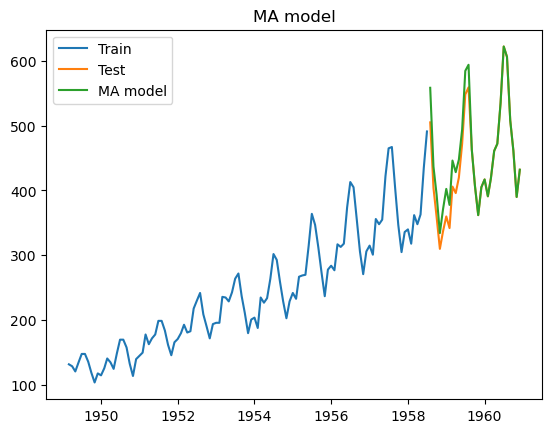

In [21]:
pred_MA_diff = pd.Series(model_fit_ma.fittedvalues, copy=True)
pred_MA_diff_cumsum = pred_MA_diff.cumsum()

pred_MA_boxcox = pd.Series(data_boxcox, index=data_boxcox.index)
pred_MA_boxcox = pred_MA_boxcox.add(pred_MA_diff_cumsum, fill_value=0)

pred_MA = inv_boxcox(pred_MA_boxcox, fitted_lambda)

plot_model_prediction(pred_MA, 'MA model', train, test)


### Modelo ARMA

In [22]:
model_arma = ARIMA(train_boxcox_second_order_diff, order=(6,0,6))
model_fit_arma = model_arma.fit()
model_fit_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  113
Model:                 ARIMA(6, 0, 6)   Log Likelihood                 119.726
Date:                Wed, 27 Nov 2024   AIC                           -211.452
Time:                        02:51:53   BIC                           -173.268
Sample:                    04-01-1950   HQIC                          -195.957
                         - 08-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.009      0.145      0.884      -0.016       0.018
ar.L1          0.0154      0.313      0.049      0.961      -0.598       0.629
ar.L2          0.3596      0.194      1.855      0.064      -0.020       0.740
ar.L3         -0.5426      0.191     -2.834      0.005      -0.918      -0.167
ar.L4          0.4128      0.161      2.561      0.010       0.097       0.729
ar.L5          0.0578      0.227      0.255      0.799      -0.386       0.502
ar.L6         -0.5502      0.155     -3.542      0.000      -0.855      -0.246
ma.L1         -0.2164      0.330     -0.656      0.512      -0.863       0.430
ma.L2         -0.2091      0.869     -0.241      0.810      -1.912       1.494
ma.L3          0.4188      0.156      2.688      0.007       0.113       0.724
ma.L4         -0.7090      1.132     -0.627      0.531      -2.927       1.509
ma.L5          0.3833      0.418      0.917      0.359      -0.435       1.202
ma.L6          0.5414      0.597      0.907      0.364      -0.628       1.711
sigma2         0.0066      0.006      1.116      0.265      -0.005       0.018
===================================================================================
Ljung-Box (L1) (Q):                   0.62   Jarque-Bera (JB):                 0.44
Prob(Q):                              0.43   Prob(JB):                         0.80
Heteroskedasticity (H):               0.39   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

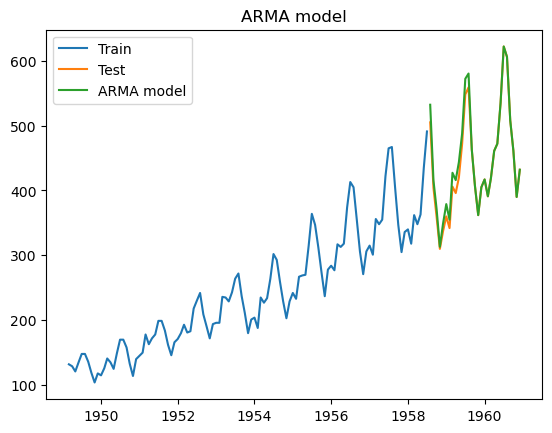

In [23]:
pred_ARMA_diff = pd.Series(model_fit_arma.fittedvalues, copy=True)
pred_ARMA_diff_cumsum = pred_ARMA_diff.cumsum()

pred_ARMA_boxcox = pd.Series(data_boxcox, index=data_boxcox.index)
pred_ARMA_boxcox = pred_ARMA_boxcox.add(pred_ARMA_diff_cumsum, fill_value=0)

pred_ARMA = inv_boxcox(pred_ARMA_boxcox, fitted_lambda)

plot_model_prediction(pred_ARMA, 'ARMA model', train, test)


### Modelo ARIMA

In [25]:
model_auto = auto_arima(train_boxcox_second_order_diff, seasonal=True, trace=True,
                        information_criterion='bic',
                        error_action='ignore', suppress_warnings=True, stepwise=True)
print(model_auto.summary())

Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : BIC=-189.938, Time=2.76 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=-192.898, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=-200.189, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=-200.131, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-197.612, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : BIC=-195.493, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=-195.697, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[0]             : BIC=-204.885, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : BIC=-200.190, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=-200.397, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=-204.818, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=inf, Time=0.22 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 4.092 seconds
                               S

In [26]:
model_arima = ARIMA(train_boxcox_second_order_diff, order=(6,0,6))
model_fit_arima = model_arima.fit()
model_fit_arima.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  113
Model:                 ARIMA(6, 0, 6)   Log Likelihood                 119.677
Date:                Wed, 27 Nov 2024   AIC                           -211.354
Time:                        04:02:40   BIC                           -173.171
Sample:                    04-01-1950   HQIC                          -195.860
                         - 08-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.008      0.150      0.881      -0.015       0.017
ar.L1          0.0151      0.289      0.052      0.958      -0.551       0.582
ar.L2          0.3511      0.193      1.818      0.069      -0.027       0.730
ar.L3         -0.5584      0.192     -2.909      0.004      -0.935      -0.182
ar.L4          0.4081      0.160      2.557      0.011       0.095       0.721
ar.L5          0.0504      0.219      0.230      0.818      -0.379       0.480
ar.L6         -0.5666      0.149     -3.794      0.000      -0.859      -0.274
ma.L1         -0.2186      0.307     -0.713      0.476      -0.819       0.382
ma.L2         -0.2195      0.906     -0.242      0.809      -1.995       1.556
ma.L3          0.4277      0.155      2.761      0.006       0.124       0.731
ma.L4         -0.7121      1.190     -0.598      0.550      -3.045       1.621
ma.L5          0.3739      0.422      0.886      0.376      -0.453       1.201
ma.L6          0.5518      0.624      0.884      0.376      -0.671       1.775
sigma2         0.0066      0.006      1.074      0.283      -0.005       0.019
===================================================================================
Ljung-Box (L1) (Q):                   0.58   Jarque-Bera (JB):                 0.46
Prob(Q):                              0.45   Prob(JB):                         0.79
Heteroskedasticity (H):               0.39   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

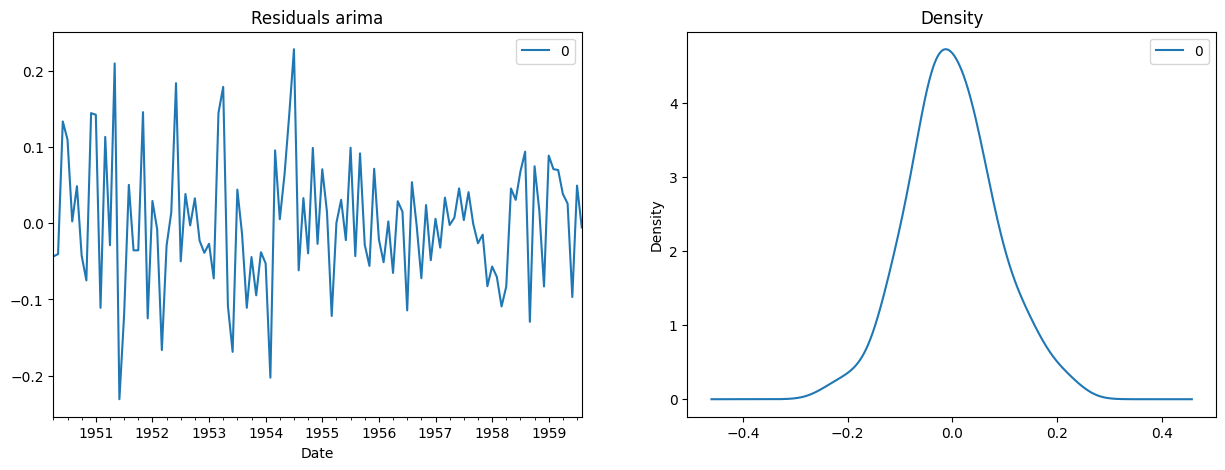

In [27]:


plot_residuals(model_fit_arima, 'arima')

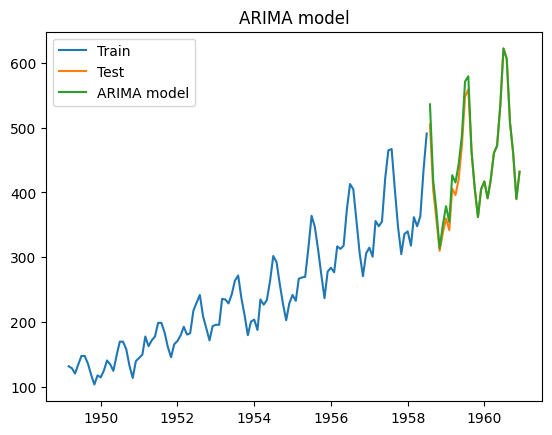

In [28]:
pred_ARIMA_diff = pd.Series(model_fit_arima.fittedvalues, copy=True)
pred_ARIMA_diff_cumsum = pred_ARIMA_diff.cumsum()

pred_ARIMA_boxcox = pd.Series(data_boxcox, index=data_boxcox.index)
pred_ARIMA_boxcox = pred_ARIMA_boxcox.add(pred_ARIMA_diff_cumsum, fill_value=0)

pred_ARIMA = inv_boxcox(pred_ARIMA_boxcox, fitted_lambda)

plot_model_prediction(pred_ARIMA, 'ARIMA model', train, test)


## Avaliação dos resultados

Para avaliar a capacidade de cada um dos modelos, foram utilizadas as seguintes métricas:
* AIC: Quanto menor, melhor.
* BIC: Similar ao AIC, mas penaliza mais os modelos complexos.
* Log Likelihood: Quanto maior, melhor.
* MSE: A média das diferenças ao quadrado entre os valores preditos e os valores reais. Valores menores indicam melhor qualidade.
* RMSE: 

Para cada um dos modelos(AR, MA, ARMA e ARIMA), foram computadas as métricas de avaliação conforme a variação dos resultados obtida pela variação dos parâmetros p, d e q conforme o que é esperado para cada um dos modelos:
- AR(p) - avalia variações de p
- MA(q) - avalia variações de q
- ARMA(p, q) - avalia variações de p, q
- ARIMA(p, d, q) - avalia variações de p, d, q

Os intervalos para cada um dos parâmetros variaram de 1 a 12 em cada modelo verificado.
As métricas computadas para cada um dos modelos foram salvas e a partir dos resultados obtidos, foi escolhido um conjunto de parâmetros que apresentou o melhor desempenho de cada modelo.
Como critérios de escolha dos parâmetros, as métricas MSE, AIC e Log-Likelihood foram selecionadas como mais relevantes pois oferencem um equilibrio entre a capacidade de predição de valores corretos e complexidade do modelo.



##### Busca de parâmetros p, d, q
faz a avaliaçao dos modelos, variando os parâmetros:
- AR avalia variações de p
- MA avalia variações de q
- ARMA avalia variações de p, q
- ARIMA avalia variações de p, d, q

In [33]:
ar_models_df = eval_model('AR', 0, 13, 0, 1, 0, 1, train_boxcox_second_order_diff, test, data_boxcox)

(0, 0, 0)
(1, 0, 0)
(2, 0, 0)
(3, 0, 0)
(4, 0, 0)
(5, 0, 0)
(6, 0, 0)
(7, 0, 0)
(8, 0, 0)
(9, 0, 0)
(10, 0, 0)
(11, 0, 0)
(12, 0, 0)


In [34]:
ma_models_df = eval_model('MA', 0, 1, 0, 1, 0, 13, train_boxcox_second_order_diff, test, data_boxcox)

(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 0, 3)
(0, 0, 4)
(0, 0, 5)
(0, 0, 6)
(0, 0, 7)
(0, 0, 8)
(0, 0, 9)
(0, 0, 10)
(0, 0, 11)
(0, 0, 12)


In [35]:
arma_models_df = eval_model('ARMA', 0, 13, 0, 1, 0, 13, train_boxcox_second_order_diff, test, data_boxcox)

(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 0, 3)
(0, 0, 4)
(0, 0, 5)
(0, 0, 6)
(0, 0, 7)
(0, 0, 8)
(0, 0, 9)
(0, 0, 10)
(0, 0, 11)
(0, 0, 12)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 0, 3)
(1, 0, 4)
(1, 0, 5)
(1, 0, 6)
(1, 0, 7)
(1, 0, 8)
(1, 0, 9)
(1, 0, 10)
(1, 0, 11)
(1, 0, 12)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)
(2, 0, 3)
(2, 0, 4)
(2, 0, 5)
(2, 0, 6)
(2, 0, 7)
(2, 0, 8)
(2, 0, 9)
(2, 0, 10)
(2, 0, 11)
(2, 0, 12)
(3, 0, 0)
(3, 0, 1)
(3, 0, 2)
(3, 0, 3)
(3, 0, 4)
(3, 0, 5)
(3, 0, 6)
(3, 0, 7)
(3, 0, 8)
(3, 0, 9)
(3, 0, 10)
(3, 0, 11)
(3, 0, 12)
(4, 0, 0)
(4, 0, 1)
(4, 0, 2)
(4, 0, 3)
(4, 0, 4)
(4, 0, 5)
(4, 0, 6)
(4, 0, 7)
(4, 0, 8)
(4, 0, 9)
(4, 0, 10)
(4, 0, 11)
(4, 0, 12)
(5, 0, 0)
(5, 0, 1)
(5, 0, 2)
(5, 0, 3)
(5, 0, 4)
(5, 0, 5)
(5, 0, 6)
(5, 0, 7)
(5, 0, 8)
(5, 0, 9)
(5, 0, 10)
(5, 0, 11)
(5, 0, 12)
(6, 0, 0)
(6, 0, 1)
(6, 0, 2)
(6, 0, 3)
(6, 0, 4)
(6, 0, 5)
(6, 0, 6)
(6, 0, 7)
(6, 0, 8)
(6, 0, 9)
(6, 0, 10)
(6, 0, 11)
(6, 0, 12)
(7, 0, 0)
(7, 0, 1)
(7, 0, 2)
(7, 0, 3)
(7, 0, 4)
(7, 0, 5)
(7, 0, 6)

In [41]:
arima_models_df = eval_model('ARIMA', 0, 13, 0, 13, 0, 13, train_boxcox_second_order_diff, test, data_boxcox)

(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 0, 3)
(0, 0, 4)
(0, 0, 5)
(0, 0, 6)
(0, 0, 7)
(0, 0, 8)
(0, 0, 9)
(0, 0, 10)
(0, 0, 11)
(0, 0, 12)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 1, 6)
(0, 1, 7)
(0, 1, 8)
(0, 1, 9)
(0, 1, 10)
(0, 1, 11)
(0, 1, 12)
(0, 2, 0)
(0, 2, 1)
(0, 2, 2)
(0, 2, 3)
(0, 2, 4)
(0, 2, 5)
(0, 2, 6)
(0, 2, 7)
(0, 2, 8)
(0, 2, 9)
(0, 2, 10)
(0, 2, 11)
(0, 2, 12)
(0, 3, 0)
(0, 3, 1)
(0, 3, 2)
(0, 3, 3)
(0, 3, 4)
(0, 3, 5)
(0, 3, 6)
(0, 3, 7)
(0, 3, 8)
(0, 3, 9)
(0, 3, 10)
(0, 3, 11)
(0, 3, 12)
(0, 4, 0)
(0, 4, 1)
(0, 4, 2)
(0, 4, 3)
(0, 4, 4)
(0, 4, 5)
(0, 4, 6)
(0, 4, 7)
(0, 4, 8)
(0, 4, 9)
(0, 4, 10)
(0, 4, 11)
(0, 4, 12)
(0, 5, 0)
(0, 5, 1)
(0, 5, 2)
(0, 5, 3)
(0, 5, 4)
(0, 5, 5)
(0, 5, 6)
(0, 5, 7)
(0, 5, 8)
(0, 5, 9)
(0, 5, 10)
(0, 5, 11)
(0, 5, 12)
(0, 6, 0)
(0, 6, 1)
(0, 6, 2)
(0, 6, 3)
(0, 6, 4)
(0, 6, 5)
(0, 6, 6)
(0, 6, 7)
(0, 6, 8)
(0, 6, 9)
(0, 6, 10)
(0, 6, 11)
(0, 6, 12)
(0, 7, 0)
(0, 7, 1)
(0, 7, 2)
(0, 7, 3)
(0, 7, 4)
(0, 7, 5)
(0, 7, 6)

In [ ]:
#salva os resultados
ar_models_df.to_csv('ar_models')
ma_models_df.to_csv('ma_models')
arma_models_df.to_csv('arma_models')
arima_models_df.to_csv('arima_models')

##### Avaliação modelo AR
- AR(12)

In [100]:
ar_models_df[ar_models_df['MSE'] < 600].sort_values(by=['MSE', 'AIC']).sort_values('Log-Likelihood', ascending=False).head(6)

,model,order,AIC,BIC,Log-Likelihood,MSE,RMSE,MAE,MAPE
12,AR,"(12, 0, 0)",-213.072385,-174.888955,120.536192,49.181364,7.012943,3.732160,0.960492
8,AR,"(8, 0, 0)",-200.725324,-173.451446,110.362662,501.555533,22.395436,14.580462,3.671172
7,AR,"(7, 0, 0)",-202.608585,-178.062095,110.304293,522.711524,22.862885,14.891521,3.742850
6,AR,"(6, 0, 0)",-203.953220,-182.134117,109.976610,539.251927,23.221799,15.129730,3.790400
5,AR,"(5, 0, 0)",-205.856453,-186.764738,109.928226,533.960256,23.107580,15.031467,3.772647
4,AR,"(4, 0, 0)",-207.824007,-191.459680,109.912004,545.184707,23.349191,15.172780,3.811493


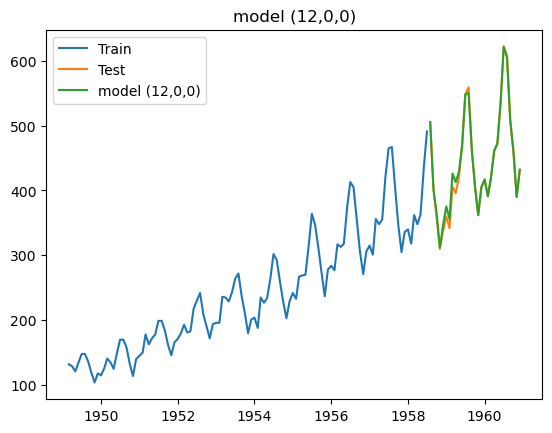

In [101]:
eval_and_plot_model(12,0,0, data_boxcox, train_boxcox_second_order_diff, train, test, fitted_lambda)

##### Avaliação modelo MA
- MA(3)

In [91]:
ma_models_df[ma_models_df['MSE'] < 500].sort_values(by=['MSE', 'AIC']).sort_values('Log-Likelihood', ascending=False).head(6)

,model,order,AIC,BIC,Log-Likelihood,MSE,RMSE,MAE,MAPE
8,MA,"(0, 0, 8)",-202.410189,-175.136310,111.205094,416.274689,20.402811,13.022487,3.298256
4,MA,"(0, 0, 4)",-207.741230,-191.376903,109.870615,437.311287,20.911989,13.535977,3.418705
3,MA,"(0, 0, 3)",-209.733899,-196.096960,109.866949,426.119050,20.642651,13.343950,3.373525
2,MA,"(0, 0, 2)",-206.325961,-195.416409,107.162980,439.910681,20.974048,13.771945,3.436921
1,MA,"(0, 0, 1)",-208.313117,-200.130953,107.156558,430.745702,20.754414,13.638510,3.399495
0,MA,"(0, 0, 0)",-198.352456,-192.897680,101.176228,180.351025,13.429483,8.846278,2.125906


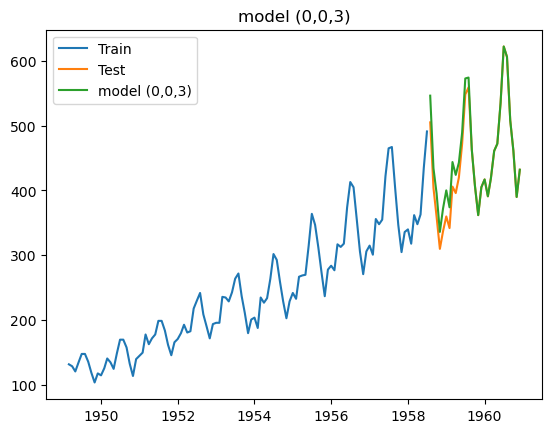

In [92]:
eval_and_plot_model(0,0,3, data_boxcox, train_boxcox_second_order_diff, train, test, fitted_lambda)

##### Avaliação modelo ARMA
- ARMA(8,7)

In [78]:
arma_models_df[arma_models_df['MSE'] < 50].sort_values(by=['MSE', 'AIC']).sort_values('Log-Likelihood', ascending=False).head(6)

,model,order,AIC,BIC,Log-Likelihood,MSE,RMSE,MAE,MAPE
140,ARMA,"(10, 0, 10)",-201.099248,-141.096716,122.549624,49.764433,7.054391,3.768731,0.980014
139,ARMA,"(10, 0, 9)",-202.082516,-144.807372,122.041258,46.699621,6.833712,3.741793,0.880603
111,ARMA,"(8, 0, 7)",-207.816275,-161.450682,120.908137,43.543467,6.598747,3.937905,0.958496
156,ARMA,"(12, 0, 0)",-213.072385,-174.888955,120.536192,49.181364,7.012943,3.732160,0.960492
46,ARMA,"(3, 0, 7)",-200.737866,-168.009212,112.368933,44.411345,6.664184,3.568286,0.812028


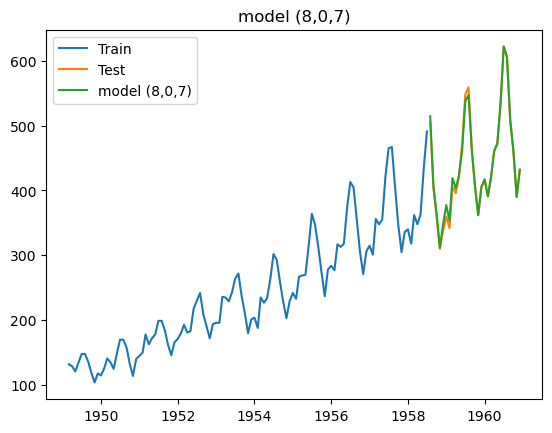

In [90]:
eval_and_plot_model(8,0,7, data_boxcox, train_boxcox_second_order_diff, train, test, fitted_lambda)

##### Avaliação modelo ARIMA
- ARIMA(10,1,6)

In [71]:
arima_models_df[arima_models_df['MSE'] < 20].sort_values(by=['MSE','AIC']).sort_values('Log-Likelihood', ascending=False).head(6)

,model,order,AIC,BIC,Log-Likelihood,MSE,RMSE,MAE,MAPE
1661,ARIMA,"(10, 1, 6)",-191.493552,-145.279071,112.746776,17.371830,4.167953,2.528595,0.633785
1823,ARIMA,"(11, 1, 3)",-193.579860,-152.802377,111.789930,18.757770,4.331024,2.546143,0.639199
1822,ARIMA,"(11, 1, 2)",-193.029971,-154.970987,110.514985,19.862050,4.456686,2.630474,0.645178
1658,ARIMA,"(10, 1, 3)",-192.450551,-154.391567,110.225276,12.771418,3.573712,1.877813,0.442569
1324,ARIMA,"(8, 1, 2)",-191.213357,-161.309869,106.606678,15.919640,3.989942,2.105315,0.500279
1338,ARIMA,"(8, 2, 3)",-179.737637,-147.223275,101.868819,17.585623,4.193522,2.102144,0.470230


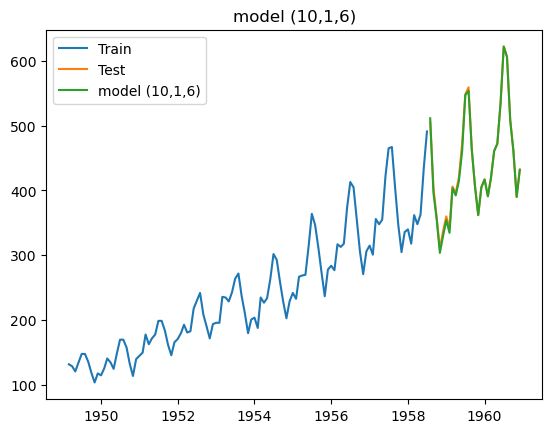

In [72]:
eval_and_plot_model(10,1,6, data_boxcox, train_boxcox_second_order_diff, train, test, fitted_lambda)

In [49]:
models = {
    'AR': model_ar,
    'MA': model_ma,
    'ARMA': model_arma,
    'ARIMA': model_arima,
    'AR_fit': model_fit_ar,
    'MA_fit': model_fit_ma,
    'ARMA_fit': model_fit_arma,
    'ARIMA_fit': model_fit_arima,
    'AR_pred': pred_AR,
    'MA_pred': pred_MA,
    'ARMA_pred': pred_ARMA,
    'ARIMA_pred': pred_ARIMA
}

In [31]:
# Dicionários para armazenar resultados
results = {}
error_metrics = {}

for name, item in models.items():
    if '_fit' in name:
        # Métricas do modelo
        aic = item.aic
        bic = item.bic
        llf = item.llf

        model_name = name.replace('_fit', '')
        order = models[model_name].order
        results[model_name] = {'order':order, 'AIC': aic, 'BIC': bic, 'Log-Likelihood': llf}
    elif '_pred' in name:
        # Métricas de erro
        model_name = name.replace('_pred', '')

        prediction = item[test.index.min():]
        actual = test['Passengers']

        mse = mean_squared_error(actual, prediction)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actual, prediction)
        mape = np.mean(np.abs((actual - prediction) / actual)) * 100

        error_metrics[model_name] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

# Convertendo para DataFrames
metrics_df = pd.DataFrame(results).T
error_metrics_df = pd.DataFrame(error_metrics).T

# Combinando todas as métricas
all_metrics = metrics_df.join(error_metrics_df)

# Ordenando os modelos pelo menor RMSE
all_metrics_sorted = all_metrics.sort_values('RMSE')

all_metrics_sorted


,order,AIC,BIC,Log-Likelihood,MSE,RMSE,MAE,MAPE
ARMA,"(6, 0, 6)",-211.354261,-173.170832,119.677131,156.935355,12.527384,7.888180,1.861726
ARIMA,"(6, 0, 6)",-211.354261,-173.170832,119.677131,156.935355,12.527384,7.888180,1.861726
AR,"(6, 0, 0)",-203.953199,-182.134097,109.9766,539.251932,23.221799,15.129730,3.790400
MA,"(0, 0, 6)",-205.500255,-183.681153,110.750128,565.077582,23.771361,15.538763,3.816215
